# Exercise 4: Transformers on Images + GLU-MLP Ablations (ViT × GLU Variants)

## In this exercise you will combine two influential ideas:

Vision Transformers (ViT) from “An Image is Worth 16×16 Words: Transformers for Image Recognition at Scale” (Dosovitskiy et al., 2020) https://arxiv.org/pdf/2010.11929:
ViT shows that you can treat an image like a sequence of tokens by splitting it into non-overlapping patches (e.g. 16×16 in the paper), embedding each patch into a vector, adding positional information, and then applying standard Transformer blocks for classification.

Gated MLPs (GLU variants) from “GLU Variants Improve Transformer” (Shazeer, 2020) https://arxiv.org/pdf/2002.05202:
Shazeer proposes replacing the standard Transformer feed-forward layer (FFN/MLP) with gated linear unit (GLU) variants such as GEGLU and SwiGLU, which often improves training dynamics and final performance under comparable compute/parameter budgets.

## What you will do

You will implement a tiny ViT-style classifier for MNIST, then run a controlled ablation where you replace the MLP inside each Transformer block:

Baseline FFN (GELU):
Linear(d_model → d_ff) → GELU → Linear(d_ff → d_model)

GLU-family MLPs (choose at least two and justify):

GEGLU, SwiGLU, other activation functions

Your goal is to evaluate whether these GLU variants change:

- convergence speed (loss vs steps),

- final test accuracy,

- and/or stability across runs.

## Key ViT concepts you will implement

- To convert MNIST images into Transformer tokens, you will:
  Patchify each 28×28 image into non-overlapping P×P patches.
  If P=4, then you get a 7×7 patch grid → 49 tokens per image.

- Embed patches with a linear layer: patch vectors → d_model.

- Add positional embeddings so the model knows where each patch came from.

- Apply n_layers Transformer encoder blocks.

- Pool token features (e.g., mean pooling) and project to 10 classes.

## Key GLU concept you will implement

GLU-style MLPs replace a standard FFN with a gating mechanism:
compute two projections a and b, apply a nonlinearity to a (variant-dependent), multiply elementwise: act(a) * b, project back to d_model.
To keep the comparison fair, use the 2/3 width rule from Shazeer.

What we provide vs what you implement

### We provide:

- MNIST loading + dataloaders

- a minimal training loop structure (AdamW)

- a suggested small model configuration that runs on CPU

### You implement:

- patch tokenization (patchify)

- patch embedding + positional embedding strategy

- a pre-LN Transformer encoder block using nn.MultiheadAttention (LN=layernorm)

- at least two GLU MLP variants + one FFN baseline

- metric logging sufficient to support your conclusion

## Deliverables

Run at least 3 variants (baseline + the activation functions you choose for GLU) and report:

- final and best test accuracy

- number of trainable parameters

- a plot or printed summary of loss/accuracy over epochs

- a short discussion of your results

In [9]:
from __future__ import annotations

import math
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [10]:
def patchify(x: torch.Tensor, patch_size: int) -> torch.Tensor:
    """Convert images to patch tokens."""
    B, C, H, W = x.shape
    P = patch_size
    Hp, Wp = H // P, W // P
    x = x.reshape(B, C, Hp, P, Wp, P)
    x = x.permute(0, 2, 4, 1, 3, 5)        # (B, Hp, Wp, C, P, P)
    x = x.reshape(B, Hp * Wp, C * P * P)   # (B, N, patch_dim)
    return x

In [11]:
# DONE: Add positional encoding as done in the ViT paper and patch projection
class PatchEmbed(nn.Module):
    def __init__(self, patch_dim: int, d_model: int):
        super().__init__()
        self.proj = nn.Linear(patch_dim, d_model)

    def forward(self, x_patches: torch.Tensor) -> torch.Tensor:
        return self.proj(x_patches)


class PositionalEmbedding(nn.Module):
    def __init__(self, num_tokens: int, d_model: int):
        super().__init__()
        self.embed = nn.Parameter(torch.zeros(num_tokens, d_model))
        nn.init.normal_(self.embed, std=0.02)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.embed

In [12]:
# DONE: Define the variants you want to compare against each other from the GLU paper. Justify your choice.
class FeedForward(nn.Module):
    """
    Standard Transformer FFN:
      x -> Linear(d_model->d_ff) -> GELU -> Dropout -> Linear(d_ff->d_model) -> Dropout
    """
    def __init__(self, d_model: int, d_ff: int, dropout: float):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class GLUFeedForward(nn.Module):
    """GLU-family FFN
    Supports
    - FFN_GLU 'glu',
    - FFN_Bilinear 'bilinear',
    - FFN_GEGLU 'geglu,
    - FFN_SwiGLU 'swiglu'
    - FFN_ReGLU 'reglu',
    """
    def __init__(self, d_model: int, d_ff_gated: int, dropout: float, variant: str):
        super().__init__()
        self.W = nn.Linear(d_model, d_ff_gated, bias=False)
        self.V = nn.Linear(d_model, d_ff_gated, bias=False)
        self.W2 = nn.Linear(d_ff_gated, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)
        assert variant in ['glu', 'bilinear', 'geglu', 'swiglu', 'reglu'], "Unknown variant passed"
        self.variant = variant

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        xW = self.W(x)
        xV = self.V(x)
        if self.variant == "glu":
            gate = torch.sigmoid(xW)
        elif self.variant == "bilinear":
            gate = xW
        elif self.variant == "geglu":
            gate = nn.functional.gelu(xW)
        elif self.variant == "swiglu":
            gate = nn.functional.silu(xW) # i think it's this one https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.silu.html
        elif self.variant == "reglu":
            gate = nn.functional.relu(xW)
        return self.dropout(self.W2(self.dropout(gate * xV)))

In [13]:
class TransformerEncoderBlock(nn.Module):
    """
    Pre-LN encoder block:
      x = x + Dropout(SelfAttn(LN(x))) (self attention => Q=K=V)
      x = x + Dropout(MLP(LN(x)))
    """
    def __init__(self, d_model: int, n_heads: int, mlp: nn.Module, dropout: float):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.mlp = mlp
        self.drop = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        normed = self.norm1(x)
        attn_out, _ = self.attn(normed, normed, normed)
        x = x + self.drop(attn_out)
        x = x + self.drop(self.mlp(self.norm2(x)))
        return x

In [14]:
class TinyViT(nn.Module):
    """
    Tiny ViT-style classifier for MNIST.
    - patchify -> patch embed -> pos embed -> blocks -> mean pool -> head

    mlp_kind: 'standard' (=ffn_gelu)', 'glu', 'bilinear', 'geglu', 'swiglu', 'reglu'
    """
    def __init__(
        self,
        patch_size: int,
        d_model: int,
        n_heads: int,
        n_layers: int,
        d_ff: int,
        dropout: float,
        mlp_kind: str,
    ):
        super().__init__()
        assert 28 % patch_size == 0
        grid = 28 // patch_size
        self.num_tokens = grid * grid
        self.patch_size = patch_size
        patch_dim = patch_size * patch_size

        # DONE: implement a strategy for embedding the patches
        self.patch_embed = PatchEmbed(patch_dim, d_model)
        self.pos_embed = PositionalEmbedding(self.num_tokens, d_model)
        self.drop = nn.Dropout(dropout)

        # DONE: implement a strategy to select the right mlp version for your experiment
        def make_mlp():
            if mlp_kind == "standard":
                return FeedForward(d_model, d_ff, dropout)
            else:
                return GLUFeedForward(d_model, int(d_ff * 2 / 3), dropout, mlp_kind)

        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(
                d_model=d_model,
                n_heads=n_heads,
                mlp=make_mlp(), # DONE: Feed your mlp to the encoder blocks
                dropout=dropout,
            )
            for _ in range(n_layers)
        ])

        # DONE: Add a head to project to the amount of output classes you have
        self.head = nn.Linear(d_model, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # DONE: Implement
        x = patchify(x, self.patch_size)
        x = self.patch_embed(x)
        x = self.pos_embed(x)
        x = self.drop(x)
        for block in self.blocks:
            x = block(x)
        x = x.mean(dim=1)
        logits = self.head(x)
        return logits

In [15]:
@dataclass(frozen=True)
class TrainConfig:
    seed: int = 0
    batch_size: int = 128
    epochs: int = 3
    lr: float = 3e-4
    weight_decay: float = 0.01
    device: str = "cpu"  # set "cuda" if available

In [16]:
# taken from ex3.ipynb
def cross_entropy_from_logits(
    logits: torch.Tensor,
    targets: torch.Tensor,
) -> torch.Tensor:
    log_probs = nn.functional.log_softmax(logits, dim=-1)
    loss = log_probs.gather(dim=1, index=targets.unsqueeze(1)).squeeze(1)
    return -loss.mean()

def train_one_run(
    mlp_kind: str,
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    cfg: TrainConfig,
) -> dict:
    model.to(cfg.device)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    train_losses: list[float] = []
    test_accs: list[float] = []

    for epoch in range(cfg.epochs):

        # Train loop
        model.train()
        for i, (xb, yb) in enumerate(train_loader):
            xb = xb.to(cfg.device)
            yb = yb.to(cfg.device)

            logits = model(xb)
            loss = cross_entropy_from_logits(logits, yb) # DONE: Your criterion

            opt.zero_grad()
            loss.backward()
            opt.step()

            train_losses.append(loss.item())

        # Evaluation loop NOTE: Should be no need to change this
        model.eval()
        correct = 0.0
        total = 0.0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(cfg.device)
                yb = yb.to(cfg.device)
                logits = model(xb)
                correct += (logits.argmax(dim=-1) == yb).float().sum().item()
                total += yb.numel()

        test_accs.append(correct / total)
        print(f"[{mlp_kind}] epoch {epoch+1}/{cfg.epochs} | test acc: {test_accs[-1]:.4f}")

    return {
        "kind":         mlp_kind,
        "train_losses": train_losses,
        "test_accs":    test_accs,
        "final_acc":    test_accs[-1],
        "best_acc":     max(test_accs),
        "n_params":     sum(p.numel() for p in model.parameters() if p.requires_grad),
    }

In [17]:
import pickle

variants = ['standard', 'glu', 'bilinear', 'geglu', 'swiglu', 'reglu']
seeds = [0, 67, 187]

tfm = transforms.Compose([transforms.ToTensor()])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=tfm)
test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=tfm)

all_results = {}

# Tiny model example. TODO: You're welcome to experiment with these parameters
patch_size = 4
d_model = 64
n_heads = 4
n_layers = 2
d_ff = 256
dropout = 0.1

for kind in variants:
    all_results[kind] = []
    for seed in seeds:
        torch.manual_seed(seed)
        
        cfg = TrainConfig(seed=seed, batch_size=128, epochs=5, lr=3e-4, weight_decay=0.01, device="cpu")
        
        train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=0, generator=torch.Generator().manual_seed(seed))
        test_loader = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=0, generator=torch.Generator().manual_seed(seed))
        
        model = TinyViT(
            patch_size=patch_size,
            d_model=d_model,
            n_heads=n_heads,
            n_layers=n_layers,
            d_ff=d_ff,
            dropout=dropout,
            mlp_kind=kind,
        )   
        n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        out = train_one_run(kind, model, train_loader, test_loader, cfg)
        out['seed'] = seed

        print(f"{kind:10s} seed={seed} | final_acc={out['final_acc']:.4f}  best_acc={out['best_acc']:.4f}  params={n_params:,}")

        all_results[kind].append(out)

with open("vit_results.pkl", "wb") as f:
    pickle.dump(all_results, f)
    print("Saved to vit_results.pkl")

[standard] epoch 1/5 | test acc: 0.7457
[standard] epoch 2/5 | test acc: 0.8653
[standard] epoch 3/5 | test acc: 0.9037
[standard] epoch 4/5 | test acc: 0.9321
[standard] epoch 5/5 | test acc: 0.9446
standard   seed=0 | final_acc=0.9446  best_acc=0.9446  params=104,842
[standard] epoch 1/5 | test acc: 0.7787
[standard] epoch 2/5 | test acc: 0.8748
[standard] epoch 3/5 | test acc: 0.9190
[standard] epoch 4/5 | test acc: 0.9331
[standard] epoch 5/5 | test acc: 0.9398
standard   seed=67 | final_acc=0.9398  best_acc=0.9398  params=104,842
[standard] epoch 1/5 | test acc: 0.7865
[standard] epoch 2/5 | test acc: 0.8752
[standard] epoch 3/5 | test acc: 0.9157
[standard] epoch 4/5 | test acc: 0.9322
[standard] epoch 5/5 | test acc: 0.9477
standard   seed=187 | final_acc=0.9477  best_acc=0.9477  params=104,842
[glu] epoch 1/5 | test acc: 0.7764
[glu] epoch 2/5 | test acc: 0.8727
[glu] epoch 3/5 | test acc: 0.9138
[glu] epoch 4/5 | test acc: 0.9330
[glu] epoch 5/5 | test acc: 0.9438
glu        s

### Plots

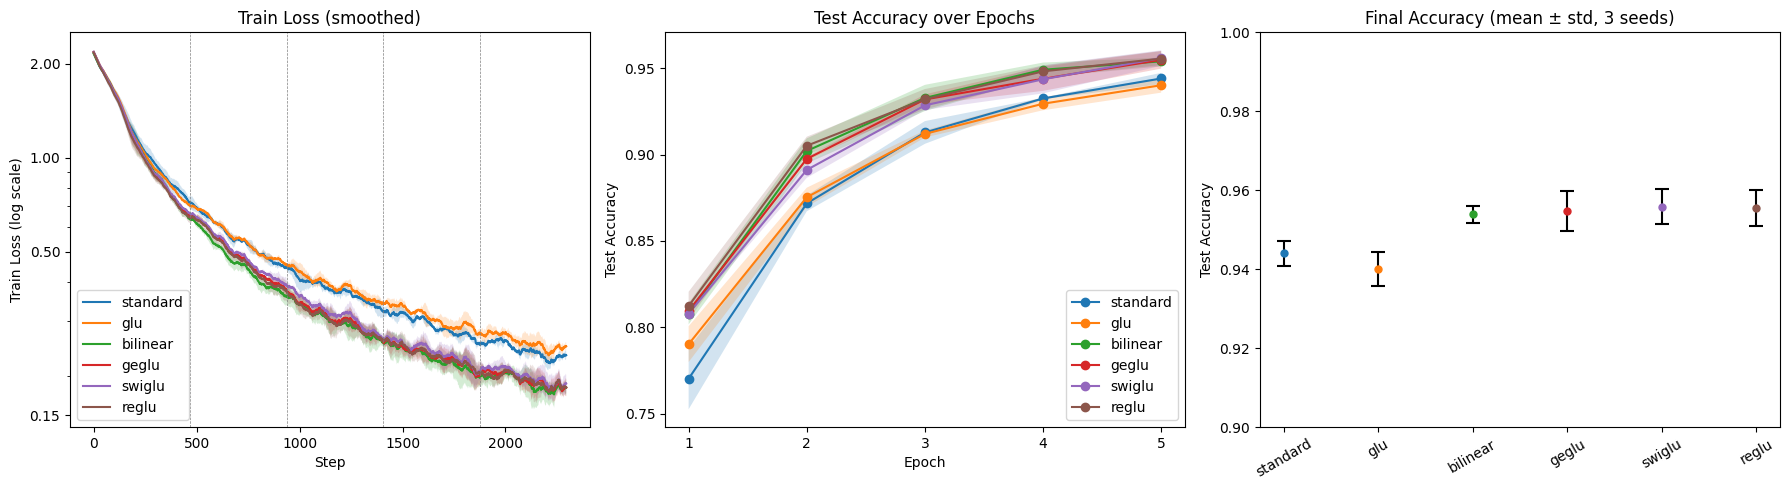

In [32]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# load all_results from pickle at "vit_results.pkl"
with open("vit_results.pkl", "rb") as f:
    all_results = pickle.load(f)

steps_per_epoch = len(train_loader)

def smooth(values, window=50):
    kernel = np.ones(window) / window
    return np.convolve(values, kernel, mode='valid')

# Plot 1 — Smoothed train loss per step
for kind, runs in all_results.items():
    losses = np.array([smooth(r['train_losses']) for r in runs])
    mean, std = losses.mean(0), losses.std(0)
    axes[0].plot(mean, label=kind)
    axes[0].fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2)

# Add epoch boundaries
for e in range(1, cfg.epochs):
    axes[0].axvline(e * steps_per_epoch, color='gray', linestyle='--', linewidth=0.5)

axes[0].set_xlabel("Step")
axes[0].set_ylabel("Train Loss (log scale)")
axes[0].set_yscale('log')
axes[0].yaxis.set_major_formatter(plt.ScalarFormatter())
axes[0].set_yticks([0.15, 0.5, 1.0, 2.0])
axes[0].set_title("Train Loss (smoothed)")
axes[0].legend()

# Plot 2 — Test accuracy over epochs
for kind, runs in all_results.items():
    accs = np.array([r['test_accs'] for r in runs])
    mean, std = accs.mean(0), accs.std(0)
    epochs_x = range(1, len(mean) + 1)
    axes[1].plot(epochs_x, mean, label=kind, marker='o')
    axes[1].fill_between(epochs_x, mean - std, mean + std, alpha=0.2)

axes[1].set_xlabel("Epoch")
axes[1].set_xticks(range(1, cfg.epochs + 1))
axes[1].set_ylabel("Test Accuracy")
axes[1].set_title("Test Accuracy over Epochs")
axes[1].legend()

kinds = list(all_results.keys())
means      = [np.mean([r['final_acc'] for r in all_results[k]]) for k in kinds]
stds       = [np.std( [r['final_acc'] for r in all_results[k]]) for k in kinds]
best_means = [np.mean([r['best_acc']  for r in all_results[k]]) for k in kinds]

color_map = {kind: line.get_color() 
             for kind, line in zip(all_results.keys(), axes[1].get_lines())}

for kind, mean, std, best in zip(kinds, means, stds, best_means):
    c = color_map[kind]
    axes[2].errorbar(kind, mean, yerr=std, fmt='o', capsize=5, markersize=5,
                     color=c, ecolor='black', capthick=1.5, label=kind)
    # axes[2].plot(kind, best, marker='*', markersize=8, color=c, alpha=0.6)

axes[2].set_ylim(0.9, 1.0)
axes[2].set_ylabel("Test Accuracy")
axes[2].set_title("Final Accuracy (mean ± std, 3 seeds)")
axes[2].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.savefig("vit_results.png", dpi=150)
plt.show()


VIDEO SCRIPT

~10s — Ex3:

"In ex3 I built an MLP classifier on MNIST achieving ~98% test accuracy. Here's the loss curve showing clean convergence."

~50s — Ex4:

"In ex4 I implemented a TinyViT comparing 6 FFN variants from the Shazeer GLU paper — the standard GELU baseline against GLU, Bilinear, ReGLU, GEGLU, and SwiGLU. We chose to compare all suggested variants to be close to the paper.

training converged for all of them, note that train loss curve is log scale to easier compare.

Each variant was run with 3 random seeds to estimate variance, can be seen in the accuracy plot for example. Note: best accuracy and test accuracy barely differ, so only final accuracy is shown

results show that the GLU methods, except vanilla GLU, outperform the baseline for the given seeds. the std deviation bands don't overlap, so we can claim statistical significance, also for this computer vision task with MNIST, not just the language tasks which were probably also harded.

compare to results from paper.

quick note on reproducibility, looking at code we can see that everything was seeded appropriately